In [1]:
# CIL core components needed
from cil.framework import ImageGeometry, AcquisitionGeometry, BlockDataContainer, DataContainer, ImageData

# CIL optimisation algorithms and linear operators
from cil.optimisation.algorithms import CGLS, PDHG, SIRT, FISTA, HybridGLSQR, GLSQR
from cil.optimisation.utilities.HybridUpdateReg import UpdateRegDiscrep, UpdateRegGCV, UpdateRegLcurve
from cil.optimisation.operators import WaveletOperator, BlockOperator, GradientOperator, IdentityOperator, FiniteDifferenceOperator
from cil.optimisation.functions import L2NormSquared, L1Norm, BlockFunction, MixedL21Norm, IndicatorBox, TotalVariation, LeastSquares

# Forward/backprojector from CIL ASTRA plugin
from cil.plugins.astra import ProjectionOperator

# Third-party imports
import numpy as np    
import matplotlib.pyplot as plt
import scipy.optimize as op

from cil.plugins.astra.operators import ProjectionOperator
from cil.plugins.astra.processors import FBP

from cil.plugins.ccpi_regularisation.functions import FGP_TV

from cil.utilities.display import show2D, show1D, show_geometry
from cil.utilities.jupyter import islicer

from cil.io import ZEISSDataReader

from cil.processors import Binner, TransmissionAbsorptionConverter, Slicer

import matplotlib.pyplot as plt
import numpy as np
import os

# Data information

In this notebook, we use the **Walnut** found in [Jørgensen_et_all](https://zenodo.org/record/4822516#.YLXyAJMzZp8). In total, there are 6 individual micro Computed Tomography datasets in the native Zeiss TXRM/TXM format. The six datasets were acquired at the 3D Imaging Center at Technical University of Denmark in 2014 (HDTomo3D in 2016) as part of the ERC-funded project High-Definition Tomography (HDTomo) headed by Prof. Per Christian Hansen. 

This example requires the dataset walnut.zip from https://zenodo.org/record/4822516 :

 - https://zenodo.org/record/4822516/files/walnut.zip

If running locally please download the data and update the `filename` variable below.

In [2]:
#Update path to location of walnut dataset
filename = "/mnt/share-private/materials/SIRF/Fully3D/CIL/Walnut/valnut_2014-03-21_643_28/tomo-A/valnut_tomo-A.txrm"

## Load walnut data

In [3]:
# read the data
reader = ZEISSDataReader()
reader.set_up(file_name=filename)
data3D = reader.read()

# reorder data to match default order for Astra operator
data3D.reorder('astra')

# Select every 25 angles: less angles will make the need for regularization greater
sliced_data = Slicer(roi={'angle':(0,1601,25)})(data3D)

# Reduce background regions
binned_data = Binner(roi={'horizontal':(120,-120,2), 'vertical': (120, -120, 2)})(sliced_data)

# Create absorption data 
data = TransmissionAbsorptionConverter()(binned_data) 

# Remove circular artifacts
data -= np.mean(data.as_array()[80:100,0:30])

# Get Image and Acquisition geometries
ag3D = data.geometry
ag3D.set_angles(ag3D.angles, initial_angle=0.2, angle_unit='radian')
ig3D = ag3D.get_ImageGeometry()

# Define projection operator
A = ProjectionOperator(ig3D, ag3D, device = "gpu")

# Check geometry
print(data)

New geometry:  3D Cone-beam tomography
System configuration:
	Source position: [   0.        , -105.05081177,    0.        ]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [ 0.        , 45.08757401,  0.        ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [1024 1024]
	Pixel size: [0.0658543 0.0658543]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 65
	Angles 0-9 in radians: [-3.1415665, -3.0434484, -2.945264 , -2.847109 , -2.7489111, -2.6507533,
 -2.5525775, -2.454381 , -2.3561862, -2.257994 ]
	Angles 55-64 in radians: [2.2580016, 2.356183 , 2.4543426, 2.5525136, 2.6507554, 2.748842 ,
 2.8470535, 2.9452505, 3.0433784, 3.1415997]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance
Shape out:  (1024, 65, 1024)
New geometry shape:  (1024, 65, 10

## Hybrid methods in action L1 Regularization

1. Discrepency
2. GCV
3. Weighted GCV
4. Adaptive Weighted GCV
5. L-curve


In [4]:
# We set a tolerance, an initial guess, and a maximum number of iterations
alpha_tol = 1e-2
maxit = 20
maxinit = 5
initial = A.domain_geometry().allocate(0)

# Tolerance for Inner Loop
atol, btol, xtol = 1e-1, 1e-1, 1e-1

# Flag to reinitialize GKB at each outer iteration
reinitialize_GKB = False

## 1. Discrepency Rule

In [5]:
# Let's say 20% noise
noiselevel = 0.2 * data.norm()
discrep_rule = UpdateRegDiscrep(data_size=data.size,
                                domain_size=initial.size, 
                                tol=alpha_tol,
                                noise_level_estimate=noiselevel)

hybridlsqrD = HybridGLSQR(operator=A, data=data, initial=initial,
                          maxoutit=maxit,
                          maxinit=maxinit,
                          atol=atol, btol=btol, xtol=xtol, reinitialize_GKB=reinitialize_GKB,
                         reg_norm_type='L1', hybrid_reg_rule=discrep_rule)
hybridlsqrD.run(maxit, verbose=True)


  0%|          | 0/20 [00:00<?, ?it/s]

The optimal parameter it finds is 0.1705649294035955 in 20 iterations


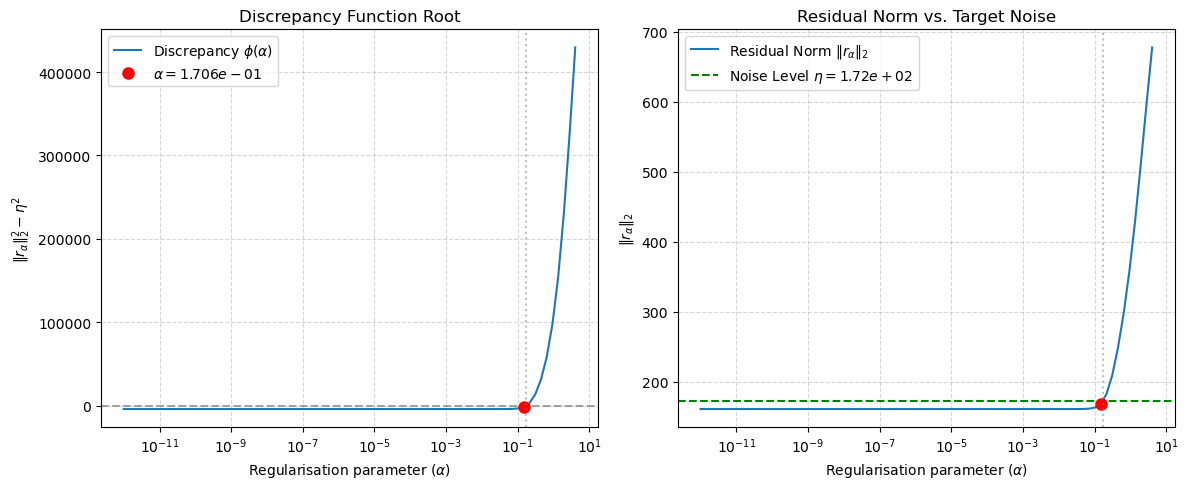

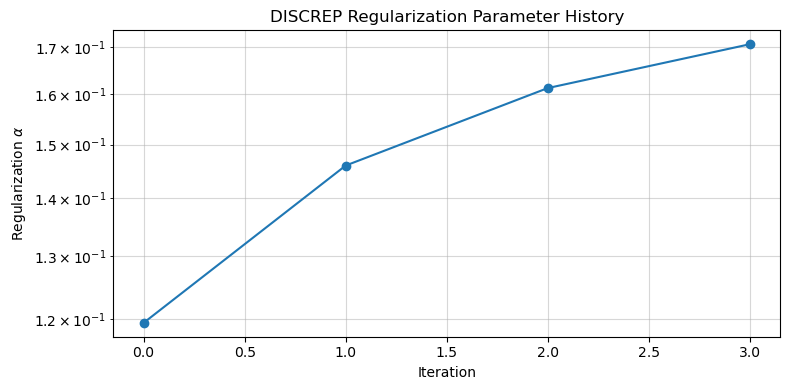

In [6]:
print("The optimal parameter it finds is", hybridlsqrD.regalpha, "in", hybridlsqrD.iteration, "iterations")

hybridlsqrD.reg_rule.plot_function()
hybridlsqrD.reg_rule.plot_history()

## 2. Standard GCV Rule

In [7]:
gcv_rule = UpdateRegGCV(data_size=data.size,
                                domain_size=initial.size, 
                                tol=alpha_tol,
                                adaptive_weight=False)

hybridlsqrgcv = HybridGLSQR(operator=A, data=data, initial=initial,
                            maxoutit=maxit,
                            maxinit=maxinit,
                            atol=atol, btol=btol, xtol=xtol, reinitialize_GKB=reinitialize_GKB,
                         reg_norm_type='L1', hybrid_reg_rule=gcv_rule)
hybridlsqrgcv.run(maxit, verbose=True)

  0%|          | 0/20 [00:00<?, ?it/s]

The optimal parameter it finds is 4.022422802371555 in 4 iterations


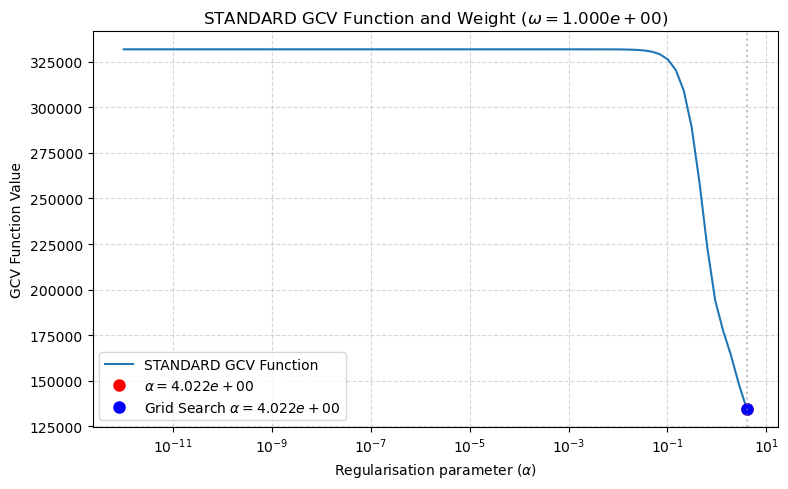

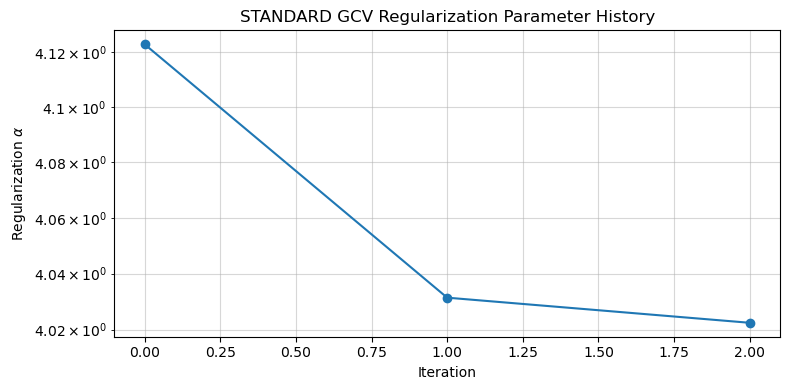

In [8]:
print("The optimal parameter it finds is", hybridlsqrgcv.regalpha, "in", hybridlsqrgcv.iteration, "iterations")

hybridlsqrgcv.reg_rule.plot_function()
hybridlsqrgcv.reg_rule.plot_history()

## 3. Weighted GCV Rule

In [9]:
wgcv_rule = UpdateRegGCV(data_size=data.size,
                                domain_size=initial.size, 
                                tol=alpha_tol,
                                gcv_weight=0.7,
                                adaptive_weight=False)

hybridlsqrwgcv = HybridGLSQR(operator=A, data=data, initial=initial,
                            maxoutit=maxit,
                            maxinit=maxinit,
                            atol=atol, btol=btol, xtol=xtol, reinitialize_GKB=reinitialize_GKB,
                            reg_norm_type='L1', hybrid_reg_rule=wgcv_rule)
hybridlsqrwgcv.run(maxit, verbose=True)

  0%|          | 0/20 [00:00<?, ?it/s]

The optimal parameter it finds is 0.1521603139155816 in 12 iterations


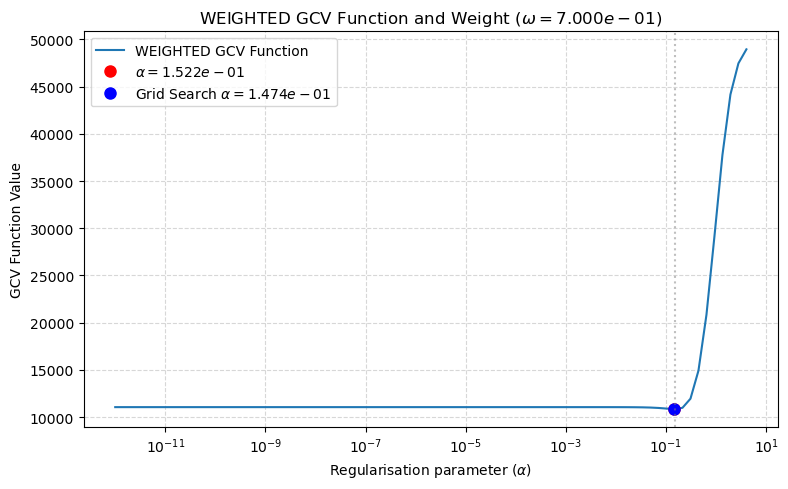

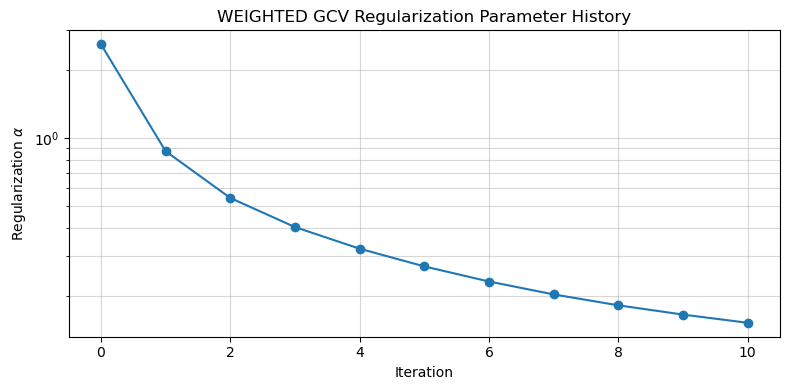

In [10]:
print("The optimal parameter it finds is", hybridlsqrwgcv.regalpha, "in", hybridlsqrwgcv.iteration, "iterations")

hybridlsqrwgcv.reg_rule.plot_function()
hybridlsqrwgcv.reg_rule.plot_history()

## 4. Adaptive-Weighted GCV Rule

In [ ]:
awgcv_rule = UpdateRegGCV(data_size=data.size,
                                domain_size=initial.size, 
                                tol=alpha_tol,
                                gcv_weight=0.7,
                                adaptive_weight=True)

hybridlsqrawgcv = HybridGLSQR(operator=A, data=data, initial=initial,
                            maxoutit=maxit,
                            maxinit=maxinit,
                            atol=atol, btol=btol, xtol=xtol, reinitialize_GKB=reinitialize_GKB,
                         reg_norm_type='L1', hybrid_reg_rule=awgcv_rule)
hybridlsqrawgcv.run(maxit, verbose=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
print("The optimal parameter it finds is", hybridlsqrawgcv.regalpha, "in", hybridlsqrawgcv.iteration, "iterations")

hybridlsqrawgcv.reg_rule.plot_function(regalpha_limits=(1e-2, 1))
hybridlsqrawgcv.reg_rule.plot_history()

NameError: name 'hybridlsqrawgcv' is not defined

## 5. L-curve Rule

Next we use generalized cross validation

In [ ]:
alpha_tol = 1e-2
lcurve_rule = UpdateRegLcurve(data_size=data.size,
                                domain_size=initial.size, 
                                tol=alpha_tol)

hybridlsqrlcurve = HybridGLSQR(operator=A, data=data, initial=initial,
                            maxoutit=maxit,
                            maxinit=maxinit,
                            atol=atol, btol=btol, xtol=xtol, reinitialize_GKB=reinitialize_GKB,
                         reg_norm_type='L1', hybrid_reg_rule=lcurve_rule)
hybridlsqrlcurve.run(maxit, verbose=True)

  0%|          | 0/50 [00:00<?, ?it/s]

The optimal parameter it finds is 0.11359105506859075 in 50 iterations


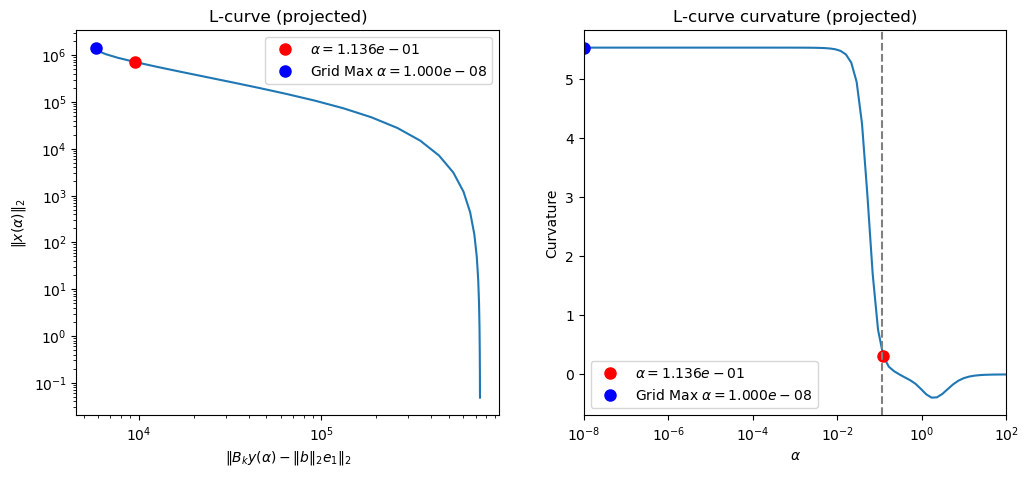

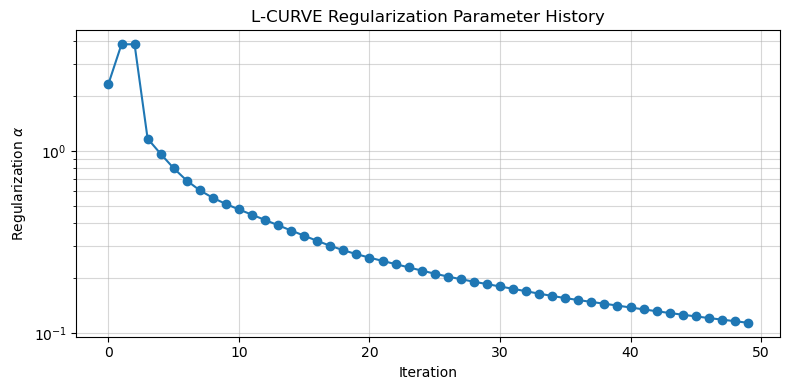

In [ ]:
print("The optimal parameter it finds is", hybridlsqrlcurve.regalpha, "in", hybridlsqrlcurve.iteration, "iterations")

hybridlsqrlcurve.reg_rule.plot_function(regalpha_limits=(1e-8, 1e2))
hybridlsqrlcurve.reg_rule.plot_history()

In [ ]:
lsqrd = GLSQR(operator=A, data=data,reg_norm_type='L1',maxinit=maxinit,
              atol=atol, btol=btol, xtol=xtol,reinitialize_GKB=reinitialize_GKB, 
              regalpha = hybridlsqrD.regalpha)
lsqrd.run(hybridlsqrD.iteration, verbose=True)

lsqrgcv = GLSQR(operator=A, data=data, reg_norm_type='L1',maxinit=maxinit,
                atol=atol, btol=btol, xtol=xtol,reinitialize_GKB=reinitialize_GKB,
                regalpha = hybridlsqrgcv.regalpha)
lsqrgcv.run(hybridlsqrgcv.iteration, verbose=True)

lsqrwgcv = GLSQR(operator=A, data=data, reg_norm_type='L1',maxinit=maxinit,
                 atol=atol, btol=btol, xtol=xtol,reinitialize_GKB=reinitialize_GKB,
                 regalpha = hybridlsqrwgcv.regalpha)
lsqrwgcv.run(hybridlsqrwgcv.iteration, verbose=True)

lsqrawgcv = GLSQR(operator=A, data=data, reg_norm_type='L1',maxinit=maxinit,
                  atol=atol, btol=btol, xtol=xtol,reinitialize_GKB=reinitialize_GKB,
                  regalpha = hybridlsqrawgcv.regalpha)
lsqrawgcv.run(hybridlsqrawgcv.iteration, verbose=True)

lsqrlcurve = GLSQR(operator=A, data=data, reg_norm_type='L1',maxinit=maxinit,
                   atol=atol, btol=btol, xtol=xtol,reinitialize_GKB=reinitialize_GKB,
                   regalpha = hybridlsqrlcurve.regalpha)
lsqrlcurve.run(hybridlsqrlcurve.iteration, verbose=True)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

The results are shown in the figure below. 

In [ ]:
from ipywidgets import interact, IntSlider, Dropdown
import matplotlib.pyplot as plt
# Define the list of solutions and titles once
solutions = [
    lsqrd.solution, 
    lsqrgcv.solution, 
    lsqrwgcv.solution, 
    lsqrawgcv.solution, 
    lsqrlcurve.solution
]

titles = [
    f'Discrep alpha = {hybridlsqrD.regalpha:.2e}',
    f'GCV alpha = {hybridlsqrgcv.regalpha:.2e}', 
    f'WGCV alpha = {hybridlsqrwgcv.regalpha:.2e}', 
    f'AWGCV alpha = {hybridlsqrawgcv.regalpha:.2e}',
    f'LCURVE alpha = {hybridlsqrlcurve.regalpha:.2e}',
]

# Mapping for the dropdown
rule_options = {
    'All Rules': None,
    'Discrepancy': 0,
    'GCV': 1,
    'WGCV': 2,
    'AWGCV': 3,
    'L-Curve': 4
}
NORM_NAME = 'L1'

def update_display(vslice, rule_name):
    # Determine which solutions to show
    idx = rule_options[rule_name]
    
    if idx is None:
        # Show all
        current_solutions = solutions
        current_titles = titles
        cols = 3
    else:
        # Show only the selected one
        current_solutions = [solutions[idx]]
        current_titles = [titles[idx]]
        cols = 1

    # Render using show2D
    fig = show2D(
        current_solutions,
        cmap='inferno', 
        fix_range=(0, 0.05), 
        slice_list=('vertical', vslice), 
        num_cols=cols,
        title=current_titles
    )
    
    # Add the overall title (suptitle)
    # We use plt.gcf() to ensure we grab the figure show2D just created
    fig = plt.gcf()
    fig.suptitle(f"Hybrid GLSQR Analysis {NORM_NAME}\nRule: {rule_name} | Vertical Slice: {vslice}", 
                 fontsize=14, fontweight='bold', y=1.05)
    
    # Adjust layout so the suptitle doesn't overlap
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Determine dimensions
max_vslice = solutions[0].shape[0] - 1

# Create the interactive dashboard
interact(
    update_display,   
    vslice=IntSlider(min=0, max=max_vslice, step=1, value=200, description='Slice:'),
    rule_name=Dropdown(options=list(rule_options.keys()), value='All Rules', description='Rule:')
);

interactive(children=(IntSlider(value=200, description='Slice:', max=391), Dropdown(description='Rule:', optio…

Some rules seem to result in quite reasonable parameters, while others oversmoothe. 

## Non-standard Tikhonov regularization

We are often interested in solving the problem with non-standard L2 regularization:
$$\underset{u}{\mathrm{min}}\begin{Vmatrix}A u - b\end{Vmatrix}_2^2 + \alpha^2\|Lu\|_2^2,$$
where $L$ is some kind of operator on the image $u$, usually a gradient/finite difference or wavelet operator. Under no assumptions on the shape regularity of $L$, this problem is equivalent to (Chung and Gazzola, 2024)
$$\bar{x}(\alpha) = \underset{\bar{x}}{\mathrm{argmin}}\begin{Vmatrix}AL_A^{\dagger}\bar{x} - \bar{b}\end{Vmatrix}_2^2 + \alpha^2\|\bar{x}\|_2^2,$$
where
- $L_A^{\dagger}$ is the $A$-weighted generalized inverse of $L$: $L_A^{\dagger} = (I -(A(I-L^{\dagger}L^{\dagger}))^{\dagger}A)L^{\dagger}$.
- $u(\alpha) = L_A^{\dagger}\bar{x}(\lambda) + u_0^L$
- $\bar{b} = b - u_0^L$
- $u_0^L$ is the component of the regularized solution $u(\lambda)$ in the null space of $L$. 

If $L$ is invertible, then $L_A^{\dagger} = L^{-1}$ and if $L$ is full column rank, then $L_A^{\dagger} = L^{\dagger}$. In either of these cases, in every iteration of Golub-Kahan bidiagonalization we must solve a linear system with $L$.